In [1]:
import numpy as np 
import pandas as pd
import datetime
import calendar
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', None)
sns.set_style('darkgrid')
%matplotlib inline

In [2]:
X_train = pd.read_csv('../data/X_train.csv', sep=',', encoding='utf-8')

In [3]:
print(len(X_train))
X_train['sepostulo'].head(2)

13097808


0     True
1    False
Name: sepostulo, dtype: bool

In [4]:
# Desordenamos para que no queden todos los true primero y los false despues
X_train = X_train.sample(len(X_train))

In [5]:
X_train['sepostulo'].head(10)

6383814      True
6317957     False
362593       True
3429951     False
2569731     False
8373798      True
10611186    False
407141      False
12541857     True
510871       True
Name: sepostulo, dtype: bool

In [6]:
target = X_train[['sepostulo']]

In [7]:
X_train.to_csv('../data/X_train.csv', index=False, sep=',', encoding='utf-8')
target.to_csv('../data/target.csv', index=False, sep=',', encoding='utf-8')

In [15]:
target = pd.read_csv('../data/target.csv', sep=',', encoding='utf-8')

In [2]:
X_train = pd.read_csv('../data/X_train.csv', sep=',', encoding='utf-8')

In [33]:
X_test = pd.read_csv('../data/X_test.csv', sep=',', encoding='utf-8')

In [34]:
X_test.shape

(100000, 52)

In [35]:
print('train shape:', X_train.shape,'| target shape:', target.shape)
print('test shape:', X_test.shape)

train shape: (13097808, 56) | target shape: (13097808, 1)
test shape: (100000, 52)


In [ ]:
X_test.duplicated('id').any()

In [29]:
X_test.head(1)

,Administración,AdministracióndePersonal,Almacén/Depósito/Expedición,AtenciónalCliente,CallCenter,Comercial,Contabilidad,CréditosyCobranzas,Gastronomia,Legal,Logística,MantenimientoyLimpieza,Marketing,Producción,Recepcionista,RecursosHumanos,Secretaria,Telemarketing,Tesorería,Ventas,cant_postulaciones_aviso,cant_vistas_aviso,desc_1,desc_2,desc_3,desc_4,desc_5,desc_6,desc_7,edad,estado_estudio_Abandonado,estado_estudio_EnCurso,estado_estudio_Graduado,idaviso,nivel_laboral_Gerencia/AltaGerencia/Dirección,nivel_laboral_Jefe/Supervisor/Responsable,nivel_laboral_Junior,nivel_laboral_Otro,nivel_laboral_Senior/Semi-Senior,nombre_estudio_Doctorado,nombre_estudio_Master,nombre_estudio_Otro,nombre_estudio_Posgrado,nombre_estudio_Secundario,nombre_estudio_Terciario/Tecnico,nombre_estudio_Universitario,sexo_FEM,sexo_MASC,sexo_NO_DECLARA,tipo_full,tipo_otro,tipo_part
0,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0,2,False,False,False,True,False,False,False,42,False,False,True,739260,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,True,False,False


In [37]:
#X_test.drop_duplicates(['idaviso', 'idpostulante'], inplace=True, keep='last')
X_test.shape

(100000, 52)

In [ ]:
ids = X_test[['id']]

In [ ]:
X_test.drop('id', axis=1, inplace=True)

In [ ]:
print('train shape:', X_train.shape,'| target shape:', target.shape)
print('test shape:', X_test.shape)

In [ ]:
ids.to_csv('test_.csv', sep=',', encoding='utf-8')

In [ ]:
print(X_train.shape)
print(X_test.shape)

In [ ]:
print(len(target[target['sepostulo'] == False]))
print(len(target[target['sepostulo'] == True]))

In [ ]:
X_train.head(1)

In [ ]:
X_test.head(1)

In [ ]:
X_test.drop(columns=['nombre_area', 'idpostulante'], inplace=True)

In [ ]:
X_train.drop(columns=['nombre_area', 'idpostulante', 'sepostulo', 'nivel_laboral_nan'], inplace=True)

In [ ]:
print(X_train.columns)
print(X_test.columns)

In [ ]:
# Ordenamos las columnas para que queden igual
#X_train = X_train.reindex_axis(sorted(X_train.columns), axis=1)
#X_test = X_test.reindex_axis(sorted(X_test.columns), axis=1)
#X_train = X_train.reindex(sorted(X_train.columns), axis=1)
#X_test = X_test.reindex(sorted(X_test.columns), axis=1)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(X_train.columns)
print(X_test.columns)

In [ ]:
X_train.dtypes

In [ ]:
X_test.dtypes

# Checkpoint 

In [40]:
# Completo
X_train.to_csv('../data/X_train.csv', index=False, sep=',', encoding='utf-8')
target.to_csv('../data/target.csv', index=False, sep=',', encoding='utf-8')

In [ ]:
X_train = pd.read_csv('../data/X_train.csv', sep=',', encoding='utf-8')
target = pd.read_csv('../data/target.csv', sep=',', encoding='utf-8')

In [3]:
# 8 millones
X_train.head(8000000).to_csv('../data/X_train_8000000.csv', index=False, sep=',', encoding='utf-8')
target.head(8000000).to_csv('../data/target_8000000.csv', index=False, sep=',', encoding='utf-8')

In [2]:
X_train = pd.read_csv('../data/X_train_8000000.csv', sep=',', encoding='utf-8')
target = pd.read_csv('../data/target_8000000.csv', sep=',', encoding='utf-8')

In [3]:
X_test = pd.read_csv('../data/X_test.csv', sep=',', encoding='utf-8')

In [5]:
print(X_train.shape)
print(X_test.shape)
print(target.shape)

(8000000, 52)
(100000, 52)
(8000000, 1)


In [11]:
X_test.drop(columns=['nombre_area', 'idpostulante'], inplace=True)

In [24]:
X_train = X_train.reindex(sorted(X_train.columns), axis=1)
X_test = X_test.reindex(sorted(X_test.columns), axis=1)

In [5]:
X_train.head(1)

,Administración,AdministracióndePersonal,Almacén/Depósito/Expedición,AtenciónalCliente,CallCenter,Comercial,Contabilidad,CréditosyCobranzas,Gastronomia,Legal,Logística,MantenimientoyLimpieza,Marketing,Producción,Recepcionista,RecursosHumanos,Secretaria,Telemarketing,Tesorería,Ventas,cant_postulaciones_aviso,cant_vistas_aviso,desc_1,desc_2,desc_3,desc_4,desc_5,desc_6,desc_7,edad,estado_estudio_Abandonado,estado_estudio_EnCurso,estado_estudio_Graduado,idaviso,nivel_laboral_Gerencia/AltaGerencia/Dirección,nivel_laboral_Jefe/Supervisor/Responsable,nivel_laboral_Junior,nivel_laboral_Otro,nivel_laboral_Senior/Semi-Senior,nombre_estudio_Doctorado,nombre_estudio_Master,nombre_estudio_Otro,nombre_estudio_Posgrado,nombre_estudio_Secundario,nombre_estudio_Terciario/Tecnico,nombre_estudio_Universitario,sexo_FEM,sexo_MASC,sexo_NO_DECLARA,tipo_full,tipo_otro,tipo_part
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0,0,False,False,False,False,False,False,False,30,False,True,False,1112390783,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,True,False


In [6]:
X_test.head(1)

,Administración,AdministracióndePersonal,Almacén/Depósito/Expedición,AtenciónalCliente,CallCenter,Comercial,Contabilidad,CréditosyCobranzas,Gastronomia,Legal,Logística,MantenimientoyLimpieza,Marketing,Producción,Recepcionista,RecursosHumanos,Secretaria,Telemarketing,Tesorería,Ventas,cant_postulaciones_aviso,cant_vistas_aviso,desc_1,desc_2,desc_3,desc_4,desc_5,desc_6,desc_7,edad,estado_estudio_Abandonado,estado_estudio_EnCurso,estado_estudio_Graduado,idaviso,nivel_laboral_Gerencia/AltaGerencia/Dirección,nivel_laboral_Jefe/Supervisor/Responsable,nivel_laboral_Junior,nivel_laboral_Otro,nivel_laboral_Senior/Semi-Senior,nombre_estudio_Doctorado,nombre_estudio_Master,nombre_estudio_Otro,nombre_estudio_Posgrado,nombre_estudio_Secundario,nombre_estudio_Terciario/Tecnico,nombre_estudio_Universitario,sexo_FEM,sexo_MASC,sexo_NO_DECLARA,tipo_full,tipo_otro,tipo_part
0,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0,2,False,False,False,True,False,False,False,42,False,False,True,739260,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,True,False,False


In [9]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000000 entries, 0 to 7999999
Data columns (total 52 columns):
Administración                                   bool
AdministracióndePersonal                         bool
Almacén/Depósito/Expedición                      bool
AtenciónalCliente                                bool
CallCenter                                       bool
Comercial                                        bool
Contabilidad                                     bool
CréditosyCobranzas                               bool
Gastronomia                                      bool
Legal                                            bool
Logística                                        bool
MantenimientoyLimpieza                           bool
Marketing                                        bool
Producción                                       bool
Recepcionista                                    bool
RecursosHumanos                                  bool
Secretaria             

In [5]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 52 columns):
Administración                                   100000 non-null bool
AdministracióndePersonal                         100000 non-null bool
Almacén/Depósito/Expedición                      100000 non-null bool
AtenciónalCliente                                100000 non-null bool
CallCenter                                       100000 non-null bool
Comercial                                        100000 non-null bool
Contabilidad                                     100000 non-null bool
CréditosyCobranzas                               100000 non-null bool
Gastronomia                                      100000 non-null bool
Legal                                            100000 non-null bool
Logística                                        100000 non-null bool
MantenimientoyLimpieza                           100000 non-null bool
Marketing                                        1

In [6]:
X_train.dtypes

Administración                                    bool
AdministracióndePersonal                          bool
Almacén/Depósito/Expedición                       bool
AtenciónalCliente                                 bool
CallCenter                                        bool
Comercial                                         bool
Contabilidad                                      bool
CréditosyCobranzas                                bool
Gastronomia                                       bool
Legal                                             bool
Logística                                         bool
MantenimientoyLimpieza                            bool
Marketing                                         bool
Producción                                        bool
Recepcionista                                     bool
RecursosHumanos                                   bool
Secretaria                                        bool
Telemarketing                                     bool
Tesorería 

In [15]:
X_train.desc_1.fillna(0, inplace=True)
X_train.desc_2.fillna(0, inplace=True)
X_train.desc_3.fillna(0, inplace=True)
X_train.desc_4.fillna(0, inplace=True)
X_train.desc_5.fillna(0, inplace=True)
X_train.desc_6.fillna(0, inplace=True)
X_train.desc_7.fillna(0, inplace=True)

In [16]:
X_train['desc_1'] = X_train['desc_1'].astype(bool)
X_train['desc_2'] = X_train['desc_2'].astype(bool)
X_train['desc_3'] = X_train['desc_3'].astype(bool)
X_train['desc_4'] = X_train['desc_4'].astype(bool)
X_train['desc_5'] = X_train['desc_5'].astype(bool)
X_train['desc_6'] = X_train['desc_6'].astype(bool)
X_train['desc_7'] = X_train['desc_7'].astype(bool)

X_train['estado_estudio_Abandonado'] = X_train['estado_estudio_Abandonado'].astype(bool)
X_train['estado_estudio_EnCurso'] = X_train['estado_estudio_EnCurso'].astype(bool)
X_train['estado_estudio_Graduado'] = X_train['estado_estudio_Graduado'].astype(bool)
X_train['nivel_laboral_Gerencia/AltaGerencia/Dirección'] = X_train['nivel_laboral_Gerencia/AltaGerencia/Dirección'].astype(bool)
X_train['nivel_laboral_Jefe/Supervisor/Responsable'] = X_train['nivel_laboral_Jefe/Supervisor/Responsable'].astype(bool)
X_train['nivel_laboral_Junior'] = X_train['nivel_laboral_Junior'].astype(bool)
X_train['nivel_laboral_Otro'] = X_train['nivel_laboral_Otro'].astype(bool)
X_train['nivel_laboral_Senior/Semi-Senior'] = X_train['nivel_laboral_Senior/Semi-Senior'].astype(bool)
X_train['nombre_estudio_Doctorado'] = X_train['nombre_estudio_Doctorado'].astype(bool)
X_train['nombre_estudio_Master'] = X_train['nombre_estudio_Master'].astype(bool)
X_train['nombre_estudio_Otro'] = X_train['nombre_estudio_Otro'].astype(bool)
X_train['nombre_estudio_Posgrado'] = X_train['nombre_estudio_Posgrado'].astype(bool)
X_train['nombre_estudio_Secundario'] = X_train['nombre_estudio_Secundario'].astype(bool)
X_train['nombre_estudio_Terciario/Tecnico'] = X_train['nombre_estudio_Terciario/Tecnico'].astype(bool)
X_train['nombre_estudio_Universitario'] = X_train['nombre_estudio_Universitario'].astype(bool)
X_train['sexo_FEM'] = X_train['sexo_FEM'].astype(bool)
X_train['sexo_MASC'] = X_train['sexo_MASC'].astype(bool)
X_train['sexo_NO_DECLARA'] = X_train['sexo_NO_DECLARA'].astype(bool)

In [17]:
X_train.dtypes

Administración                                    bool
AdministracióndePersonal                          bool
Almacén/Depósito/Expedición                       bool
AtenciónalCliente                                 bool
CallCenter                                        bool
Comercial                                         bool
Contabilidad                                      bool
CréditosyCobranzas                                bool
Gastronomia                                       bool
Legal                                             bool
Logística                                         bool
MantenimientoyLimpieza                            bool
Marketing                                         bool
Producción                                        bool
Recepcionista                                     bool
RecursosHumanos                                   bool
Secretaria                                        bool
Telemarketing                                     bool
Tesorería 

In [18]:
X_test.dtypes

idaviso                                          int64
edad                                             int64
nombre_estudio_Doctorado                          bool
nombre_estudio_Master                             bool
nombre_estudio_Otro                               bool
nombre_estudio_Posgrado                           bool
nombre_estudio_Secundario                         bool
nombre_estudio_Terciario/Tecnico                  bool
nombre_estudio_Universitario                      bool
estado_estudio_Abandonado                         bool
estado_estudio_EnCurso                            bool
estado_estudio_Graduado                           bool
sexo_FEM                                          bool
sexo_MASC                                         bool
sexo_NO_DECLARA                                   bool
desc_1                                            bool
desc_2                                            bool
desc_3                                            bool
desc_4    

In [19]:
X_test.desc_1.fillna(0, inplace=True)
X_test.desc_2.fillna(0, inplace=True)
X_test.desc_3.fillna(0, inplace=True)
X_test.desc_4.fillna(0, inplace=True)
X_test.desc_5.fillna(0, inplace=True)
X_test.desc_6.fillna(0, inplace=True)
X_test.desc_7.fillna(0, inplace=True)

In [20]:
X_test['desc_1'] = X_test['desc_1'].astype(bool)
X_test['desc_2'] = X_test['desc_2'].astype(bool)
X_test['desc_3'] = X_test['desc_3'].astype(bool)
X_test['desc_4'] = X_test['desc_4'].astype(bool)
X_test['desc_5'] = X_test['desc_5'].astype(bool)
X_test['desc_6'] = X_test['desc_6'].astype(bool)
X_test['desc_7'] = X_test['desc_7'].astype(bool)

X_test['estado_estudio_Abandonado'] = X_test['estado_estudio_Abandonado'].astype(bool)
X_test['estado_estudio_EnCurso'] = X_test['estado_estudio_EnCurso'].astype(bool)
X_test['estado_estudio_Graduado'] = X_test['estado_estudio_Graduado'].astype(bool)
X_test['nivel_laboral_Gerencia/AltaGerencia/Dirección'] = X_test['nivel_laboral_Gerencia/AltaGerencia/Dirección'].astype(bool)
X_test['nivel_laboral_Jefe/Supervisor/Responsable'] = X_test['nivel_laboral_Jefe/Supervisor/Responsable'].astype(bool)
X_test['nivel_laboral_Junior'] = X_test['nivel_laboral_Junior'].astype(bool)
X_test['nivel_laboral_Otro'] = X_test['nivel_laboral_Otro'].astype(bool)
X_test['nivel_laboral_Senior/Semi-Senior'] = X_test['nivel_laboral_Senior/Semi-Senior'].astype(bool)
X_test['nombre_estudio_Doctorado'] = X_test['nombre_estudio_Doctorado'].astype(bool)
X_test['nombre_estudio_Master'] = X_test['nombre_estudio_Master'].astype(bool)
X_test['nombre_estudio_Otro'] = X_test['nombre_estudio_Otro'].astype(bool)
X_test['nombre_estudio_Posgrado'] = X_test['nombre_estudio_Posgrado'].astype(bool)
X_test['nombre_estudio_Secundario'] = X_test['nombre_estudio_Secundario'].astype(bool)
X_test['nombre_estudio_Terciario/Tecnico'] = X_test['nombre_estudio_Terciario/Tecnico'].astype(bool)
X_test['nombre_estudio_Universitario'] = X_test['nombre_estudio_Universitario'].astype(bool)
X_test['sexo_FEM'] = X_test['sexo_FEM'].astype(bool)
X_test['sexo_MASC'] = X_test['sexo_MASC'].astype(bool)
X_test['sexo_NO_DECLARA'] = X_test['sexo_NO_DECLARA'].astype(bool)

In [21]:
X_test.dtypes

idaviso                                          int64
edad                                             int64
nombre_estudio_Doctorado                          bool
nombre_estudio_Master                             bool
nombre_estudio_Otro                               bool
nombre_estudio_Posgrado                           bool
nombre_estudio_Secundario                         bool
nombre_estudio_Terciario/Tecnico                  bool
nombre_estudio_Universitario                      bool
estado_estudio_Abandonado                         bool
estado_estudio_EnCurso                            bool
estado_estudio_Graduado                           bool
sexo_FEM                                          bool
sexo_MASC                                         bool
sexo_NO_DECLARA                                   bool
desc_1                                            bool
desc_2                                            bool
desc_3                                            bool
desc_4    

In [22]:
target.shape

(8000000, 1)

In [27]:
X_train.head(8000000).to_csv('../data/X_train_8000000.csv', index=False, sep=',', encoding='utf-8')
X_test.to_csv('../data/X_test.csv', index=False, sep=',', encoding='utf-8')

In [28]:
print(len(X_train))
print(len(target))

8000000
8000000


# Exportamos una muestra mas "chica" pero significativa de los datos para hacer feature selection y busqueda de hiperparametros

In [38]:
X_train.head(5000000).to_csv('../data/X_train_5000000.csv', index=False, sep=',', encoding='utf-8')
target.head(5000000).to_csv('../data/target_5000000.csv', index=False, sep=',', encoding='utf-8')

In [15]:
X_train = pd.read_csv('../data/X_train_5000000.csv', sep=',', encoding='utf-8')
target = pd.read_csv('../data/target_5000000.csv', sep=',', encoding='utf-8')

In [16]:
X_train.head(2000000).to_csv('../data/X_train_2000000.csv', index=False, sep=',', encoding='utf-8')
target.head(2000000).to_csv('../data/target_2000000.csv', index=False, sep=',', encoding='utf-8')

In [17]:
X_train = pd.read_csv('../data/X_train_2000000.csv', sep=',', encoding='utf-8')
target = pd.read_csv('../data/target_2000000.csv', sep=',', encoding='utf-8')

In [8]:
print(X_train.shape)
print(target.shape)

(5000000, 52)
(5000000, 1)


# Cross-validation

In [21]:
from sklearn.model_selection import cross_val_score, KFold
# seed para generar los mismos fold en cada cv
seed = 7
kfold = KFold(3,random_state=seed) # 3 sino tarda demasiado
scoring = 'roc_auc'
def cv_score(model,X,y,cv):
    #return cross_val_score(model,X,y,n_jobs=-1,cv=cv,scoring=scoring,verbose=3).mean()
    return cross_val_score(model,X,y,n_jobs=1,cv=cv,scoring=scoring,verbose=3).mean()

## **Rankeo de algoritmos**

In [14]:
print(len(target[target['sepostulo'] == False]))
print(len(target[target['sepostulo'] == True]))

2480299
2519701


In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

models = []
models.append(('RFC',RandomForestClassifier(n_jobs=1)))
models.append(('DecTree',DecisionTreeClassifier()))
models.append(('LogReg',LogisticRegression()))
models.append(('KNN',KNeighborsClassifier()))
models.append(('LDA',LinearDiscriminantAnalysis()))
models.append(('GaussianNB',GaussianNB()))
#models.append(('SVC',SVC())) # no termina
#models.append(('MLP',MLPClassifier(max_iter=200))) # no termina

In [16]:
%%time
scores = []
for name,model in models:
    print('################################',name,'################################')
    score = cv_score(model, X_train, target.values.ravel(), cv=kfold)
    scores.append((name,score))

################################ RFC ################################
[CV]  ................................................................
[CV] ....................... , score=0.8733602432199534, total= 3.3min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.3min remaining:    0.0s


[CV] ........................ , score=0.872719408031591, total= 3.6min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  6.9min remaining:    0.0s


[CV] ....................... , score=0.8725393049391241, total= 3.7min
################################ DecTree ################################
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 10.6min finished


[CV] ....................... , score=0.7863271447258187, total= 1.2min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s


[CV] ....................... , score=0.7861246088574287, total= 1.2min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.5min remaining:    0.0s


[CV] ....................... , score=0.7861754459587876, total= 1.3min
################################ LogReg ################################
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.7min finished


[CV] ....................... , score=0.7919273171277426, total=  39.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   39.9s remaining:    0.0s


[CV] ....................... , score=0.7802610252816817, total=  37.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.3min remaining:    0.0s


[CV] ....................... , score=0.7916158486019067, total=  38.8s
################################ KNN ################################
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.9min finished


[CV] ....................... , score=0.8707579545052886, total= 3.7min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.7min remaining:    0.0s


[CV] ....................... , score=0.8707438067452093, total= 3.3min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  7.0min remaining:    0.0s


[CV] ........................ , score=0.870511667884609, total= 3.3min
################################ LDA ################################
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 10.2min finished
/home/tbotalla/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


[CV] ....................... , score=0.7785716147826597, total= 1.2min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s
/home/tbotalla/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


[CV] ....................... , score=0.7781420158328239, total=  57.3s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.2min remaining:    0.0s


[CV]  ................................................................


/home/tbotalla/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


[CV] ....................... , score=0.7778662478770434, total= 1.0min
################################ GaussianNB ################################


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.2min finished


[CV]  ................................................................
[CV] ....................... , score=0.8087686538422251, total=  24.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   25.5s remaining:    0.0s


[CV] ....................... , score=0.8082253481084644, total=  18.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   44.4s remaining:    0.0s


[CV] ........................ , score=0.808353476330964, total=  19.7s
CPU times: user 29min 2s, sys: 53.4 s, total: 29min 56s
Wall time: 30min 47s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.1min finished


In [17]:
print('\n============== RANKING =================')
for name,score in sorted(scores,key=lambda x: x[1],reverse=True):
    print(name,':',score)


============== RANKING =================
RFC : 0.8728729853968895
KNN : 0.8706711430450357
GaussianNB : 0.8084491594272177
LogReg : 0.7879347303371104
DecTree : 0.7862090665140117
LDA : 0.7781932928308423


In [49]:
scoresDf = pd.DataFrame(scores)
scoresDf.columns = ['Algoritmo', 'Score']
scoresDf = scoresDf.sort_values(['Score'], ascending=False)
scoresDf

,Algoritmo,Score
5,RFC,0.872873
2,KNN,0.870671
1,GaussianNB,0.808449
4,LogReg,0.787935
0,DecTree,0.786209
3,LDA,0.778193


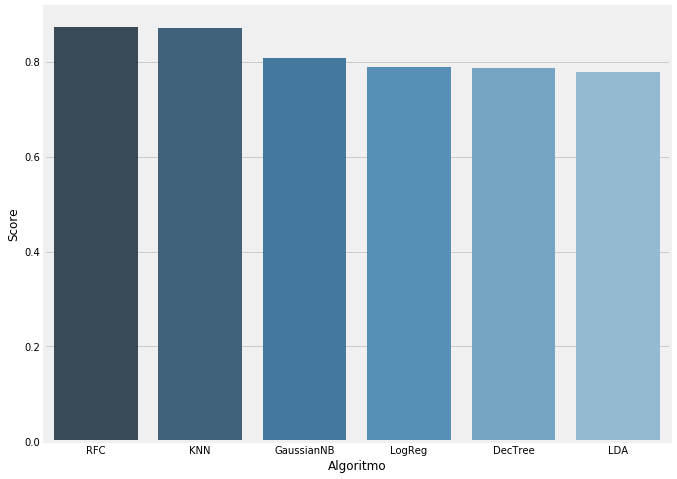

In [61]:
f, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x='Algoritmo', y='Score', data=scoresDf, palette="Blues_d")

### **Rankeamos con los datos estandarizados/normalizados**

In [17]:
from sklearn.preprocessing import scale, normalize

In [18]:
X_train = scale(X_train)

/home/tbotalla/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [ ]:
%%time
scores = []
for name,model in models:
    print('################################',name,'################################')
    score = cv_score(model, X_train, target.values.ravel(), cv=kfold)
    scores.append((name,score))

################################ RFC ################################
[CV]  ................................................................
[CV] ....................... , score=0.8728884942941646, total=11.0min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 11.0min remaining:    0.0s


[CV]  ................................................................
[CV] ....................... , score=0.8732271553166235, total=11.4min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 22.4min remaining:    0.0s


[CV]  ................................................................
[CV] ....................... , score=0.8736933061809599, total=12.0min
################################ DecTree ################################


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 34.5min finished


[CV]  ................................................................


In [ ]:
print('\n============== RANKING Scaled =================')
for name,score in sorted(scores,key=lambda x: x[1],reverse=True):
    print(name,':',score)

In [ ]:
X_train = normalize(X_train)

In [ ]:
%%time
scores = []
for name,model in models:
    print('################################',name,'################################')
    score = cv_score(model, X_train, target.values.ravel(), cv=kfold)
    scores.append((name,score))

In [ ]:
print('\n============== RANKING Normalized =================')
for name,score in sorted(scores,key=lambda x: x[1],reverse=True):
    print(name,':',score)

# Feature Selection

In [5]:
scoring = 'roc_auc'
seed = 7
def select_features(model,X,y):
    from sklearn.feature_selection import RFECV
    rfecv = RFECV(estimator=model, n_jobs=1, scoring=scoring, verbose=3)
    rfecv.fit(X, y)
    return rfecv.support_

In [6]:
best_models = []
best_models.append(('RFC',RandomForestClassifier(n_jobs=1)))
best_models.append(('KNN',KNeighborsClassifier()))
best_models.append(('DecTree',DecisionTreeClassifier()))

In [ ]:
%%time
best_features_mask = []
for name,model in best_models:
    print('##################################',name,'##################################')
    features = select_features(model, X_train, target.values.ravel())
    best_features_mask.append((name, features))

################################## DecTree ##################################
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with

In [ ]:
for model_name,features_mask in best_features_mask:
    print('=================================',model_name,'=================================')
    print('number of features:',len(X_train.columns[features_mask]))
    print(X_train.columns[features_mask])

# Grid Search

In [18]:
scoring = 'roc_auc'
seed = 7
def select_params(model,params,X,y):
    from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
    gs = GridSearchCV(model,params,cv=kfold,n_jobs=-1,verbose=3,scoring=scoring)
    #rs = RandomizedSearchCV(model,params, cv=kfold, n_jobs=2, verbose=3, scoring=scoring, random_state=seed)
    gs.fit(X,y)
    #rs.fit(X,y)
    return gs.best_params_
    #return rs.best_params_

In [30]:
# Solo para los mejores modelos
best_models = []
best_models.append(('RFC',RandomForestClassifier(n_jobs=1)))
best_models.append(('DecTree',DecisionTreeClassifier()))
best_models.append(('KNN',KNeighborsClassifier()))

In [31]:
%%time
from scipy.stats import randint, expon ,uniform, gamma, alpha
params = {}
params.update({'RFC':[{'n_estimators': [10, 12, 14]}]})
params.update({'DecTree':[{'min_samples_split': [2, 3, 4]}]})
params.update({'KNN':[{'leaf_size': [20,30,40]}, {'p': [1,2,3]}, {'weights': ['uniform', 'distance']}]})

best_params = []
for name, model in best_models:
    params = select_params(model,params[name], X_train, target.values.ravel())
    best_params.append((name, params))

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] leaf_size=20 ....................................................
[CV] leaf_size=20 ....................................................
[CV] leaf_size=20 ....................................................
[CV] leaf_size=30 ....................................................
[CV] ........... leaf_size=30, score=0.8621915463631297, total= 3.3min
[CV] leaf_size=30 ....................................................
[CV] ........... leaf_size=20, score=0.8621596534077605, total= 3.4min
[CV] leaf_size=30 ....................................................
[CV] ........... leaf_size=20, score=0.8626297346609069, total= 3.4min
[CV] leaf_size=40 ....................................................
[CV] ........... leaf_size=20, score=0.8619422050796579, total= 3.3min
[CV] leaf_size=40 ....................................................
[CV] ........... leaf_size=30, score=0.8625699683657022, total= 2.8min
[CV] leaf_size=40

[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 43.9min finished


CPU times: user 51 s, sys: 5.35 s, total: 56.4 s
Wall time: 44min 39s


In [32]:
# best_params_knn = [('KNN', {'p': 1})]
# best_params_dectree = [('DecTree', {'min_samples_split': 4})]
# best_params_rfc = [('RFC', {'n_estimators': 14})]
best_params

[('KNN', {'p': 1})]

In [29]:
best_params

[('DecTree', {'min_samples_split': 4})]

In [26]:
best_params

[('RFC', {'n_estimators': 14})]

** Train test split**

In [33]:
from sklearn.model_selection import cross_val_score, train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train, target, test_size = 0.33, random_state = 0)
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

X_train : (8775627, 46)
X_test : (4322325, 46)
y_train : (8775627, 1)
y_test : (4322325, 1)


# Predicciones

In [62]:
def predict(model,X_train,X_test,y):
    model.fit(X_train,y.values.ravel())
    return model.predict(X_test)

def pred_to_csv(prediction,name):
    test = pd.read_csv('test_.csv')
    df = pd.DataFrame(prediction,columns={'sepostulo'})
    df['id'] = test.id
    df = df.loc[:,['id','sepostulo']]
    df.sepostulo = df.sepostulo.astype(int)
    df.to_csv('pred_' + name + '.csv',index=False)

In [68]:
%%time
# Random Forest
from sklearn.ensemble import RandomForestClassifier

pred = predict(RandomForestClassifier(), X_train, X_test, target)
pred_to_csv(pred,'RandomForestClassifier') # 0.77 score en kaggle

CPU times: user 10min 18s, sys: 4.75 s, total: 10min 22s
Wall time: 10min 51s


In [69]:
len(X_train)

8000000

In [33]:
%%time
# KNN
from sklearn.neighbors import KNeighborsClassifier

pred = predict(KNeighborsClassifier(), X_train, X_test, target)
pred_to_csv(pred,'KNeighborsClassifier') # 0.76 score en kaggle

CPU times: user 11min 46s, sys: 11.4 s, total: 11min 57s
Wall time: 12min 51s


In [17]:
%%time
# SGD
from sklearn.linear_model import SGDClassifier

pred = predict(SGDClassifier(), X_train, X_test, target)
pred_to_csv(pred,'SGD')

/home/tbotalla/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


CPU times: user 1min 4s, sys: 26.1 s, total: 1min 30s
Wall time: 6min 57s


In [34]:
%%time
# Decision Tree
from sklearn.tree import DecisionTreeClassifier

pred = predict(DecisionTreeClassifier(), X_train, X_test, target)
pred_to_csv(pred,'DecisionTreeClassifier') # 0.7 score en kaggle

CPU times: user 4min 20s, sys: 8.39 s, total: 4min 29s
Wall time: 5min 11s


In [12]:
print(X_train.shape)
print(X_test.shape)
print(target.shape)

(12000000, 45)
(100000, 45)
(12000000, 1)


# Entrega final

In [2]:
X_train = pd.read_csv('../data/X_train_8000000.csv', sep=',', encoding='utf-8')
target = pd.read_csv('../data/target_8000000.csv', sep=',', encoding='utf-8')

In [3]:
X_test = pd.read_csv('../data/X_test.csv', sep=',', encoding='utf-8')

In [5]:
print(X_train.shape)
print(X_test.shape)
print(target.shape)

(8000000, 52)
(100000, 52)
(8000000, 1)


In [8]:
def train(model,X_train,X_test,y):
    model.fit(X_train,y.values.ravel())
    return model

def pred_to_csv(prediction,name):
    test = pd.read_csv('test_.csv')
    df = pd.DataFrame(prediction,columns={'sepostulo'})
    df['id'] = test.id
    df = df.loc[:,['id','sepostulo']]
    df.sepostulo = df.sepostulo.astype(int)
    df.to_csv('pred_' + name + '.csv',index=False)

In [9]:
%%time
# Random Forest
from sklearn.ensemble import RandomForestClassifier

model = train(RandomForestClassifier(n_estimators=14), X_train, X_test, target)

CPU times: user 15min 54s, sys: 7.16 s, total: 16min 2s
Wall time: 16min 26s


In [10]:
import pickle
filename = 'rfc_model.sav'

In [12]:
%%time
pickle.dump(model, open(filename, 'wb')) # Export del modelo

CPU times: user 3.41 s, sys: 3.44 s, total: 6.85 s
Wall time: 57.5 s


In [13]:
%%time
model = pickle.load(open(filename, 'rb'))

CPU times: user 1.06 s, sys: 3.4 s, total: 4.46 s
Wall time: 7.69 s


In [14]:
%%time
pred = model.predict(X_test)
pred_to_csv(pred,'RandomForestClassifier')

CPU times: user 1.22 s, sys: 52 ms, total: 1.27 s
Wall time: 1.63 s
